$\large Logica \  Computacional\ 26-Outubro-2023 \ LCC$

$\textbf{Grupo 06:}$

* João Manuel Franqueira da Silva, A91638
* Eduardo Manuel Sousa Pereira, A70619

$\huge TP2 - Problema\ 2 $

O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito.

In [1]:
from pysmt.shortcuts import *
import pysmt.typing as types
import random
from pysmt.shortcuts import Symbol, INT, Solver, Or, And
from pysmt.typing import BOOL, REAL, INT, BVType, STRING

1. O espaço de estados é definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N^2\;$ células são aqui referidas como “normais”. 

2. Inicialmente todas as células normais estão mortas excepto  as células $\,i,j \leq 3\,$que estão vivas. Um estado onde todas as células normais estão mortas é um “estado de erro”.

3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,1/2\,$ de estarem vivas.

4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

${\normalsize\text{Construir uma máquina de estados finita que represente o autómato.}}$ 

Vamos começar por declarar as variaveis relativas ao nosso problema:

Seja $N=5$, temos então:
- $5*N=25$ células normais
- $2*N+1=11$ células de borda

Para auxiliar as operações de matrizes, consideremos a variavél $mat$ como a matriz que representa o estado do nosso programa, juntamente com as células de borda, temos entao uma matriz $n$ x $n$ em que $n=N+1=6$ 

Temos também a variavél $viz$ que $\forall_{i=1}^{N} \forall_{j=1}^{N}$ $viz[i][j]$ $==$ $sumvizinhos(mat[i][j])$

In [2]:
N=4
n=N+1

def declare(a): 
    state={}
    state['mat']={}
    for i in range(n):
        state['mat'][i] = {}
        for j in range(n):
            state['mat'][i][j] = Symbol(f'mat-ij_{i}_{j}'+str(a), INT)
            
    state['viz']={}
    for i in range(n):
        state['viz'][i] = {}
        for j in range(n):
            state['viz'][i][j] = Symbol(f'viz-ij_{i}_{j}'+str(a), INT)
    
    return state

Para definir o predicado init, que dado um estado e uma posição, indica se este corresponde a um estado inicial ou não, precisamos de observar a pré-condição do nosso programa:

$ i  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad i  \text{\(\leq\)} 3 \quad \text{\(\land\)} \quad j  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad j  \text{\(\leq\)} 3 \quad \text{\(\implies\)} \quad mat[i][j]==1$ 

$ i \text{\(\geq\)}  4 \quad \text{\(\land\)} \quad i  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad j  \text{\(\geq\)} 1 \quad \text{\(\land\)} \quad j  \text{\(\leq\)}  N \quad \text{\(\implies\)} \quad mat[i][j]==0$ 

$ i  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad i  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad j  \text{\(\geq\)}  4 \quad \text{\(\land\)} \quad j  \text{\(\leq\)}  N \quad \text{\(\implies\)} \quad mat[i][j]==0$ 

Todas estas implicações podem ser reescritas apenas com o uso de conjunções e negações, visto que fórmulas $a  \text{\(\land\)} b   \text{\(\iff\)} \text{\(\neg\)} (a  \text{\(\land\)}  \text{\(\neg\)}b)$ são equivalentes, ou seja, têm o mesmo valor lógico.

In [3]:
def init(state,i,j):
    #adicionar random.choices 
    A=Not(And(
        GE(Int(i),Int(1)),
        LE(Int(i),Int(3)),
        GE(Int(j),Int(1)),
        LE(Int(j),Int(3)),
        Not(Equals(state['mat'][i][j],Int(1)))
    ))
    B=Not(And(
        GE(Int(i),Int(4)),
        LE(Int(i),Int(n-1)),
        GE(Int(j),Int(1)),
        LE(Int(j),Int(n-1)),
        Not(Equals(state['mat'][i][j],Int(0)))
    ))
    C=Not(And(
        GE(Int(i),Int(1)),
        LE(Int(i),Int(n-1)),
        GE(Int(j),Int(4)),
        LE(Int(j),Int(n-1)),
        Not(Equals(state['mat'][i][j],Int(0)))
    ))
    D=And(LE(state['mat'][i][j],Int(1)), GE(state['mat'][i][j],Int(0)))
    
    E=Not(And(
        Or(Equals(Int(i),Int(0)),Equals(Int(j),Int(0))),
        Not(Equals(state['mat'][i][j],Int(random.choice([0 , 1]))))
    ))
        
    return And(A,B,C,D,E)    

Para auxílio, temos a função $sao\_viz$ que dadas duas posições $(i0,j0)$ $(i1,j1)$, testa se correspondem a duas posições vizinhas.

Ainda definimos a função $soma\_viz$ que dada um estado $S$ e uma posição$(i, j)$, retorna a soma de todos os seus vizinhos na matriz.

In [4]:
def sao_viz(i0, j0, i1, j1):
    return (i0 != i1 or j0 != j1) and abs(i0 - i1) <= 1 and abs(j0 - j1) <= 1

def soma_viz(state,i0,j0):
    x=0
    for i in range(n):
        for j in range(n):
            if sao_viz(i0,j0,i,j):
                x=x+state['mat'][i][j]
    return x

Definimos agora a função transição que recebe dois estados como argumento e uma posição $(i,j)$, o estado atual $(curr)$ e o estado $(prox)$ a transitar para, e verifica se esses dois estados se referem a uma transição válida.
Dependendo da posição passada como argumento temos as seguintes transições possíveis:

- $(i == 0 \quad \text{\(\lor\)} \quad j == 0) \quad \text{\(\land\)} \quad curr(mat[i][j]) == prox(mat[i][j])$

- $ i  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad i  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad j  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad j  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad curr(mat[i][j])==0 \quad \text{\(\land\)} \quad curr(viz[i][j])==3 \quad \text{\(\implies\)} \quad prox(mat[i][j])==1 $

- $ i  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad i  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad j  \text{\(\geq\)}  1 \quad \text{\(\land\)} \quad j  \text{\(\leq\)}  N \quad \text{\(\land\)} \quad curr(mat[i][j])==0 \quad \text{\(\land\)} \quad curr(viz[i][j])\text{\(\neq\)} 3 \quad \text{\(\implies\)} \quad prox(mat[i][j])==0 $

- $ (i  \text{\(\geq\)}  1)  \text{\(\land\)} (i  \text{\(\leq\)}  N) \text{\(\land\)} (j  \text{\(\geq\)}  1) \text{\(\land\)} (j  \text{\(\leq\)}  N) \text{\(\land\)} (curr(mat[i][j])==1) \text{\(\land\)} (curr(viz[i][j])==3 \text{\(\lor\)} curr(viz[i][j])==2) \quad \text{\(\implies\)} \quad prox(mat[i][j])==1 $

- $ (i  \text{\(\geq\)}  1)\text{\(\land\)}(i  \text{\(\leq\)}  N) \text{\(\land\)} (j  \text{\(\geq\)}  1)\text{\(\land\)} (j  \text{\(\leq\)}  N) \text{\(\land\)} (curr(mat[i][j])==1) \text{\(\land\)} \text{\(\neg\)}(curr(viz[i][j])==3 \quad\text{\(\lor\)}\quad curr(viz[i][j])==2) \quad \text{\(\implies\)} \quad prox(mat[i][j])==0 $

Temos, também que, para qualquer transição:
- $curr(viz[i][j])==soma\_viz(curr,i,j)$

In [5]:
def trans(curr,prox,i,j):
    #CELULAS DE BORDO SÃO SEMPRE IGUAIS
    A=Equals(Int(i),Int(0))
    B=LE(Int(j),Int(n-1))
    C=Equals(curr['mat'][i][j],prox['mat'][i][j])
    D=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    b1=And(A,B,C,D)
    
    A=Equals(Int(j),Int(0))
    B=LE(Int(i),Int(n-1))
    C=Equals(curr['mat'][i][j],prox['mat'][i][j])
    D=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    b2=And(A,B,C,D)
    
    #SO NASCE SE TEM 3 VIZINHOS VIVOS
    A=GE(Int(i),Int(1))
    B=LE(Int(i),Int(n-1))
    C=GE(Int(j),Int(1))
    D=LE(Int(j),Int(n-1))
    E=Equals(curr['mat'][i][j],Int(0))
    F=Equals(curr['viz'][i][j],Int(3))
    G=Equals(prox['mat'][i][j],Int(1))
    H=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    v1=And(A,B,C,D,E,F,G,H)
    
    A=GE(Int(i),Int(1))
    B=LE(Int(i),Int(n-1))
    C=GE(Int(j),Int(1))
    D=LE(Int(j),Int(n-1))
    E=Equals(curr['mat'][i][j],Int(0))
    F=Not(Equals(curr['viz'][i][j],Int(3)))
    G=Equals(prox['mat'][i][j],Int(0))
    H=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    v2=And(A,B,C,D,E,F,G,H)
        
    #SO NASCE SE TEM 3 OU 2 VIZINHOS VIVOS
    A=GE(Int(i),Int(1))
    B=LE(Int(i),Int(n-1))
    C=GE(Int(j),Int(1))
    D=LE(Int(j),Int(n-1))
    E=Equals(curr['mat'][i][j],Int(1))
    F=Or(Equals(curr['viz'][i][j],Int(3)),Equals(curr['viz'][i][j],Int(2)))
    G=Equals(prox['mat'][i][j],Int(1))
    H=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    v3=And(A,B,C,D,E,F,G,H)

    A=GE(Int(i),Int(1))
    B=LE(Int(i),Int(n-1))
    C=GE(Int(j),Int(1))
    D=LE(Int(j),Int(n-1))
    E=Equals(curr['mat'][i][j],Int(1))
    F=Not(Or(Equals(curr['viz'][i][j],Int(3)),Equals(curr['viz'][i][j],Int(2))))
    G=Equals(prox['mat'][i][j],Int(0))
    H=Equals(curr['viz'][i][j],soma_viz(curr,i,j))
    v4=And(A,B,C,D,E,F,G,H)
    
    return Or(b1,b2,v1,v2,v3,v4)

Por ultimo, temos a função $gera$, que cria uma lista "traço" de k estados em que:

- Aplicamos a função init ao primeiro estado:  $init (traco[0])$

- Para todos estado consecutivos, aplicamos a função transição:  $\forall_{i=0}^{k-2}$ $trans (traco[i], traco[i+1])$

In [6]:
def gera(declare,init,trans,k):

    with Solver() as solver:
        traco=[]
        for i in range(k):
            x=declare(i)
            traco.append(x)

        for i in range(n):
            for j in range(n):
                solver.add_assertion(init(traco[0],i,j))
                    
        for t in range(k-1):
            for i in range(n):
                for j in range(n):
                    solver.add_assertion(trans(traco[t],traco[t+1],i,j))
            
        if solver.solve():
            print("> is sat")
            for t in range(k):
                print("ESTADO %s"%(t))
                print("")
                for i in range(n):
                    for j in range(n):
                        print(solver.get_value(traco[t]['mat'][i][j]),end=" ")
                    print("")
                print("")
        else:
            print("> not sat")

${\normalsize\text{Pretende-se provar as seguintes propriedades:}}$ 
1. Nunca se alcança o estado de erro.

Um dado estado $S$, é considerado estado de erro quando todas as celulas normais da matriz se encontram mortas, ou seja:
- $\forall_{i=1}^{N}$ $S(mat[i][j])==0$

Consideremos o predicado da função $cel\_nao\_morta$, que dado um estado, e uma posição $(i,j)$ testa se esta célula se encontra viva.

In [7]:
def cel_nao_morta(state,i,j):
    return Equals(state['mat'][i][j],Int(1))

- Podemos então considerar a função $mat\_nao\_morta$, que dado um estado $S$, calcula $\forall_{i=1}^{N}$ $\forall_{j=1}^{N}$ $cel\_nao\_morta(S,i,j)$, guardando os vários resultados, por último aplica uma disjunção entre estes.
No fundo, este predicado testa se pelo menos uma célula normal da matriz se encontra viva.

In [8]:
def mat_nao_morta(state):   
    A=[]
    for i in range(1,n):
        for j in range(1,n):
            A.append(cel_nao_morta(state,i,j))
    return Or(A)

2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.
- Consideremos a função $muda$ que dado um estado $S$ e uma posição $(i, j)$, devolve um predicado, que verifica se no próximo $S'$, $S'[mat][i][j]$ sofrerá alguma alteração, em comparação com o valor de $S[mat][i][j]$.

In [9]:
#FUNCAO TESTA SE UMA CELULA NA MATRIZ,NAO ESTA ESTAGNADA, OU SEJA, PODE MUDAR NO PROXIMO ESTADO
def muda(state,i,j): 
    A=And(Equals(state['mat'][i][j], Int(0)),Equals(state['viz'][i][j],Int(3)))
    B=And(Equals(state['mat'][i][j], Int(1)), Or(Equals(state['viz'][i][j],Int(3)),Equals(state['viz'][i][j],Int(2))))
    return Or(A,B)

- Podemos agora desenvolver a função $n\_estagnado$ que testa se dado um estado $S$, pelo menos uma das células normais não se encontra num estado estagnado, ou seja, não satistaz o predicado da função $muda$. Caso isto não se verifique, concluimos que todas as células normais do estado $S$ se encontram permanentemente mortas, ou vivas, para quaisqueres próximos estados $S'$ $S''$ $S'''$...

In [10]:
#FUNCAO QUE TESTA SE PELO MENOS UMA CELULA DA MATRIZ NAO ESTA ESTAGNADA
def n_estagnado(state):
    A=[]
    for i in range(1,n):
        for j in range(1,n):
            A.append(muda(state,i,j))
            
    return Or(*A)

Mais uma vez, para verificar se o programa nunca atinge um estado, onde todas as células normais se encontram permanentemente vivas ou mortas, podemos novamente utilizar o método da $k\_indução$, sendo desta vez o nosso invariante, a condição de que a partir de um estado $S$, para um estado $S'$ existe pelo menos uma célula normal $(i, j)$, tal que $S[mat][i][j] \text{\(\neq\)} S'[mat][i][j]$. Ou seja, satisfaz o predicado da função $n\_estagnado$.

Para a verificação destas propriedados, vamos utilizar uma versão diferente do predicado $init$, uma versão em que a atribuição de valores para as células de borda, não tenha probabilidade de $1/2$, a atribuição dos valores às células normais será realizada diretamente pelo solver, com o intuito de procurar um contra exemplo aos invariantes a provar. Note-se, que, esta versão alterada da $init$, cumpre todos os pré-requesitos para um estado inicial, desde que as células de borda sejam limitadas entre $0$ e $1$. 
Seja então $init2$:

In [11]:
def init2(state,i,j): 
    A=Not(And(
        GE(Int(i),Int(1)),
        LE(Int(i),Int(3)),
        GE(Int(j),Int(1)),
        LE(Int(j),Int(3)),
        Not(Equals(state['mat'][i][j],Int(1)))
    ))
    B=Not(And(
        GE(Int(i),Int(4)),
        LE(Int(i),Int(n-1)),
        GE(Int(j),Int(1)),
        LE(Int(j),Int(n-1)),
        Not(Equals(state['mat'][i][j],Int(0)))
    ))
    C=Not(And(
        GE(Int(i),Int(1)),
        LE(Int(i),Int(n-1)),
        GE(Int(j),Int(4)),
        LE(Int(j),Int(n-1)),
        Not(Equals(state['mat'][i][j],Int(0)))
    ))
    
    D=And(LE(state['mat'][i][j],Int(1)), GE(state['mat'][i][j],Int(0)))
    
    return And(A,B,C,D)    

Queremos verificar que o programa nunca atinge um estado de erro, e que nenhuma célula normal está permanentemente morta ou permanentemente viva. Para verificar estas duas propriedades, podemos utilizar o método da $k\_induction$, já utilizado no problema anterior, juntamente com a função $init2$, como referida anteriormente.

In [12]:
def k_induction_always(declare,init2,trans,inv,k):

    with Solver() as solver:
        s = [declare(i) for i in range(k)]
        
        for i in range(n):
            for j in range(n):
                solver.add_assertion(init2(s[0],i,j))
                solver.add_assertion(GE(s[0]['mat'][i][j],Int(0)))
                solver.add_assertion(LE(s[0]['mat'][i][j],Int(1)))
        for t in range(k-1):
            for i in range(n):
                for j in range(n):
                    solver.add_assertion(trans(s[t],s[t+1],i,j))
            
        for i in range(k):
            solver.push()
            solver.add_assertion(Not(inv(s[i])))
            if solver.solve():
                print(f"> Contradição! O invariante não se verifica nos k estados iniciais.")
                for t,state in enumerate(s):
                    print("estado: (%s)"%t)
                    for i in range(n):
                        for j in range(n):
                            print(solver.get_value(state['mat'][i][j]),end=" ")
                        print("")
                    print("-----------------------------------------------")
                    print("")
                    
                return
            solver.pop()
        
        s2 = [declare(i+k) for i in range(k+1)]

        for t in range(k):
            solver.add_assertion(inv(s2[t]))
            for i in range(n):
                for j in range(n):
                    solver.add_assertion(trans(s2[t],s2[t+1],i,j))
                
        solver.add_assertion(Not(inv(s2[-1])))
        
        if solver.solve():
            print(f"> Contradição! O passo indutivo não se verifica.")
            for t,state in enumerate(s2):
                print("estado: %s"%t)
                for i in range(n):
                    for j in range(n):
                        print(solver.get_value(state['mat'][i][j]),end=" ")
                    print("")
                print("-------------------------------------------")
                print("")
            return
        
        print(f"> A propriedade verifica-se por k-indução (k={k}).")      

In [13]:
gera(declare,init,trans,10)

> is sat
ESTADO 0

1 1 0 0 1 
1 1 1 1 0 
1 1 1 1 0 
1 1 1 1 0 
0 0 0 0 0 

ESTADO 1

1 1 0 0 1 
1 0 0 0 1 
1 0 0 0 1 
1 0 0 1 0 
0 1 1 0 0 

ESTADO 2

1 1 0 0 1 
1 0 0 1 1 
1 1 0 1 1 
1 0 1 1 0 
0 1 1 0 0 

ESTADO 3

1 1 0 0 1 
1 0 0 0 0 
1 0 0 0 0 
1 0 0 0 1 
0 1 1 1 0 

ESTADO 4

1 1 0 0 1 
1 0 0 0 0 
1 1 0 0 0 
1 0 1 1 0 
0 1 1 1 0 

ESTADO 5

1 1 0 0 1 
1 0 0 0 0 
1 0 1 0 0 
1 0 0 1 0 
0 1 0 1 0 

ESTADO 6

1 1 0 0 1 
1 0 0 0 0 
1 0 0 0 0 
1 0 0 1 0 
0 0 1 0 0 

ESTADO 7

1 1 0 0 1 
1 0 0 0 0 
1 1 0 0 0 
1 1 0 0 0 
0 0 0 0 0 

ESTADO 8

1 1 0 0 1 
1 0 0 0 0 
1 0 0 0 0 
1 1 0 0 0 
0 0 0 0 0 

ESTADO 9

1 1 0 0 1 
1 0 0 0 0 
1 0 0 0 0 
1 1 0 0 0 
0 0 0 0 0 



In [14]:
k_induction_always(declare,init2,trans,mat_nao_morta, 20)

> Contradição! O invariante não se verifica nos k estados iniciais.
estado: (0)
1 1 1 0 0 
0 1 1 1 0 
1 1 1 1 0 
0 1 1 1 0 
0 0 0 0 0 
-----------------------------------------------

estado: (1)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 1 
0 0 0 1 0 
0 0 1 0 0 
-----------------------------------------------

estado: (2)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 1 0 
0 0 0 0 0 
-----------------------------------------------

estado: (3)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (4)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (5)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (6)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (7)
1 1 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

esta

In [15]:
k_induction_always(declare,init2,trans,n_estagnado,15)

> Contradição! O invariante não se verifica nos k estados iniciais.
estado: (0)
0 0 1 0 0 
0 1 1 1 0 
1 1 1 1 0 
0 1 1 1 0 
0 0 0 0 0 
-----------------------------------------------

estado: (1)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 1 
0 0 0 1 0 
0 0 1 0 0 
-----------------------------------------------

estado: (2)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 1 0 
0 0 0 0 0 
-----------------------------------------------

estado: (3)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (4)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (5)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (6)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

estado: (7)
0 0 1 0 0 
0 0 0 0 0 
1 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
-----------------------------------------------

esta

${\LARGE\text{Impressão dos resultados obtidos}}$

$gera(declare,init,trans,10)$

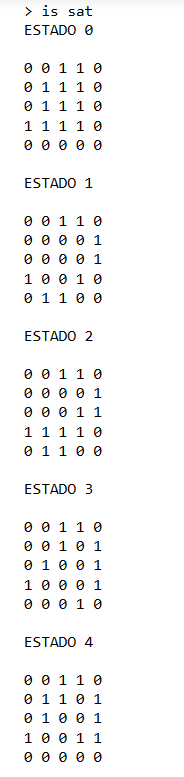

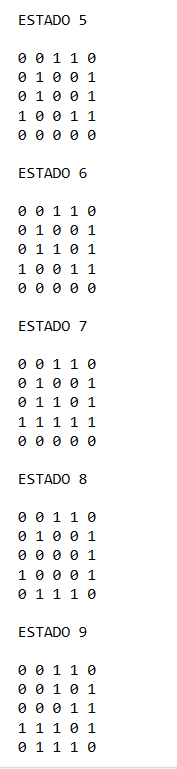

$k\_induction\_always(declare,init2,trans,mat\_nao\_morta, 20)$

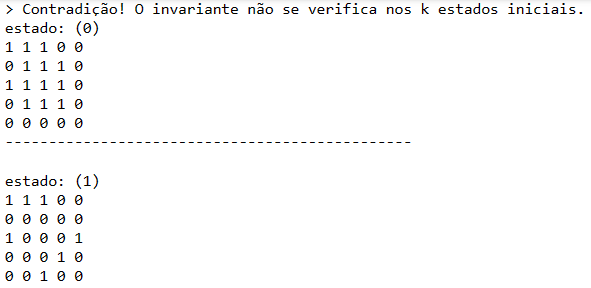

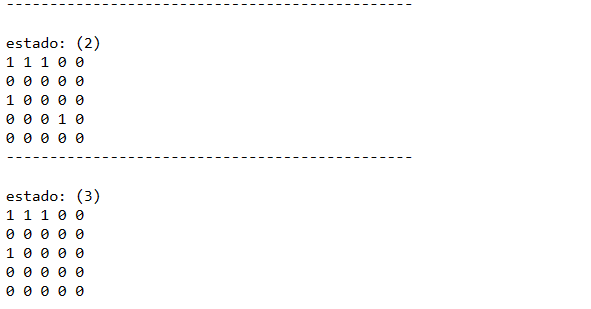

$k\_induction\_always(declare,init2,trans,n\_estagnado,15)$

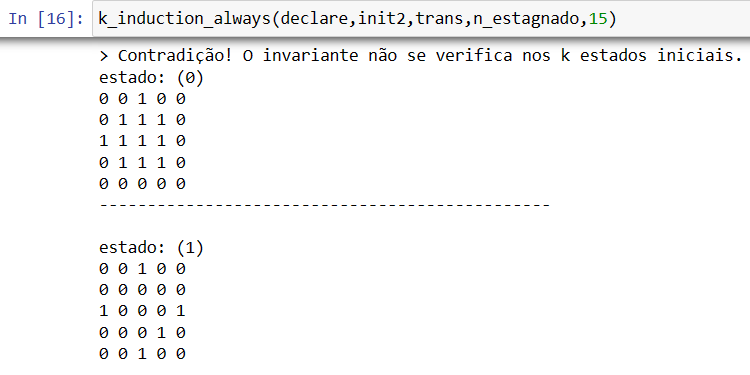

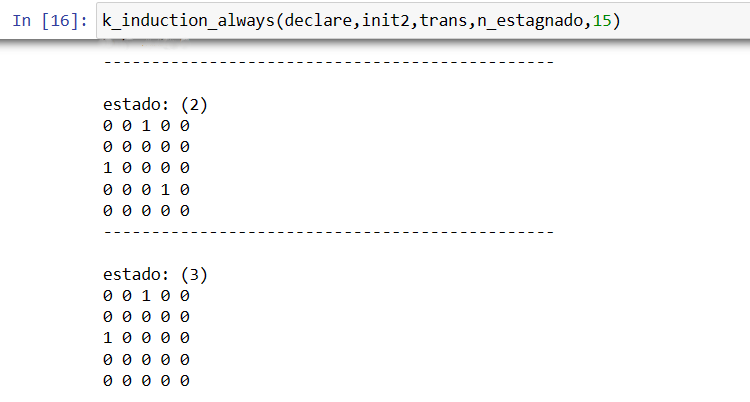

Como podemos ver, tanto existe uma configuração inicial possível e válida que conduz o programa a estado de erro como outra que leva o programa a estagnar, isto é, em que algumas células se encontram permanentemente vivas ou mortas.
Concluimos então que o programa não é seguro.